# Grid subsistence data by community (all resources, all months)

In [5]:
import glob
import pandas as pd
import geopandas as gpd
import numpy as np
import geopandas as gpd
import cmocean
import rasterio
from rasterio.features import rasterize
import cartopy
import shapely.wkt
from tqdm import trange
import matplotlib.pyplot as plt
import matplotlib as mpl

In [6]:
outdir = '../../outputs/OSRA/subsistence-actual/'

In [7]:
#raster resolution in meters
pixel_size=500

#bounds of output grid in lat/lon
output_min_lon = -168
output_max_lon = -141
output_min_lat = 69
output_max_lat = 73

# Lat/Lon CRS
crs_latlon = {'init': 'epsg:4326'}

# Equal area projection
crs_ea = {'init': 'epsg:3338'}

In [8]:
ls "../../data/subsistence/complete dataset/"

Fishnet.CPG                       Kaktovik_Resource_Month.csv
Fishnet.OBJECTID.atx              NAS16 Data Deliverable Memo_Year 2_6-1-18.pdf
Fishnet.dbf                       Nuiqsut_All_Resource.csv
Fishnet.prj                       Nuiqsut_All_Resources_Month.csv
Fishnet.sbn                       Nuiqsut_Geodataframe.geojson
Fishnet.sbx                       Nuiqsut_Resource.csv
Fishnet.shp                       Nuiqsut_Resource_Month.csv
Fishnet.shp.xml                   Utqiagvik_All_Resource.csv
Fishnet.shx                       Utqiagvik_All_Resources_Month.csv
Kaktovik_All_Resource.csv         Utqiagvik_Geodataframe.geojson
Kaktovik_All_Resources_Month.csv  Utqiagvik_Resource.csv
Kaktovik_Geodataframe.geojson     Utqiagvik_Resource_Month.csv
Kaktovik_Resource.csv


In [9]:
fishnet = gpd.read_file('../../data/subsistence/complete dataset/Fishnet.shp')
fishnet.columns = map(str.lower, fishnet.columns)
fishnet.set_index('objectid', inplace=True)

print('CRS: ', fishnet.crs, '\n\nShape: ', fishnet.shape)

CRS:  {'no_defs': True, 'x_0': 0, 'units': 'm', 'datum': 'WGS84', 'y_0': 0, 'lat_0': 90, 'lon_0': -150, 'proj': 'laea'} 

Shape:  (24177, 3)


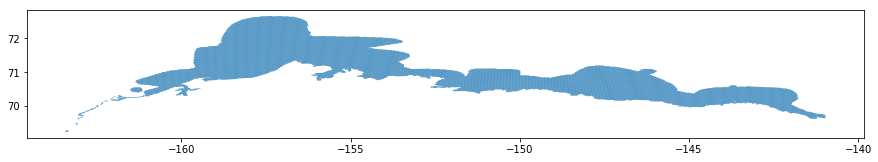

In [10]:
fishnet.to_crs(crs_latlon).plot(figsize=(15,5))

In [11]:
fishnet.head()

,shape_leng,shape_area,geometry
objectid,,,
1,6437.36,2.589975e+06,"POLYGON ((335330.6236000024 -2235131.3598, 335..."
2,6437.36,2.589975e+06,"POLYGON ((336939.9636000022 -2235131.3598, 336..."
3,6437.36,2.589975e+06,"POLYGON ((338549.3036000002 -2235131.3598, 338..."
4,6437.36,2.589975e+06,"POLYGON ((340158.6435999982 -2235131.3598, 340..."
5,6437.36,2.589975e+06,"POLYGON ((341767.9836000036 -2235131.3598, 341..."


In [12]:
def csv_to_gpd(filename):
    data = pd.read_csv(filename)
    data.columns = map(str.lower, data.columns)
#     data.drop(columns='geometry', inplace=True)
    data.set_index('objectid', inplace=True)
    
    result = fishnet.merge(data, how='left', left_index=True, right_index=True)
    result = gpd.GeoDataFrame(result, crs=fishnet.crs, geometry='geometry')
    
    return result

In [13]:
def remove_null_rows(data, column):
    result = data[pd.notnull(data[column])]
    return result

In [14]:
crs = cartopy.crs.epsg(3338)
crs_proj4 = crs.proj4_init

land_10m = cartopy.feature.NaturalEarthFeature('physical', 'land', '10m',
                                        edgecolor='gray',
                                        facecolor=cartopy.feature.COLORS['land'])

def plot_subsistence(gdf, column, units, title, data_min=0, data_max=8000):

    to_plot = gdf.to_crs(crs_proj4)
    
    cmap = cmocean.cm.matter
    norm = mpl.colors.Normalize(vmin=data_min, vmax=data_max)

    fig = plt.figure(figsize=(20,8))

    # [left, bottom, width, height]
    ax = plt.axes(projection=crs)

    # Assure that the colorbar is the same height as the plot
    pos = ax.get_position()
    cbax = fig.add_axes([0.9, pos.y0, 0.02, pos.y1-pos.y0])

    # Map
    ax.set_title(title, fontsize=20)
    ax.set_xmargin(0.05)
    ax.set_ymargin(0.10)
    #ax.set_global()
    ax.set_extent((-168, -141, 69, 73))
    ax.gridlines(zorder=0, color='lightgray')
    ax.add_feature(land_10m)

    for i in trange(len(to_plot)):
        color = cmap(norm(to_plot[column].iloc[i]))

        cell = cartopy.feature.ShapelyFeature([to_plot['geometry'].iloc[i]], crs=crs,
                                              edgecolor = color, facecolor = color)
        ax.add_feature(cell)

    # Colorbar

    cbar = mpl.colorbar.ColorbarBase(cbax, cmap=cmap,
                                    norm=norm,
                                    orientation='vertical',
                                    extend='max')
    cbar.ax.tick_params(labelsize=12)
    cbar.set_label(units, fontsize=14)

    plt.show()

# All Resource

In [15]:
kaktovik = csv_to_gpd('../../data/subsistence/complete dataset/Kaktovik_All_Resource.csv')
kaktovik = remove_null_rows(kaktovik, 'mean')

In [17]:
nuiqsut = csv_to_gpd('../../data/subsistence/complete dataset/Nuiqsut_All_Resource.csv')
nuiqsut = remove_null_rows(nuiqsut, 'mean')

In [18]:
utqiagvik = csv_to_gpd('../../data/subsistence/complete dataset/Utqiagvik_All_Resource.csv')
utqiagvik = remove_null_rows(utqiagvik, 'mean')

# Rasterize subsistence

In [19]:
kaktovik.head()

,shape_leng,shape_area,geometry,mean,community
objectid,,,,,
1,6437.36,2.589975e+06,"POLYGON ((335330.6236000024 -2235131.3598, 335...",15.394422,Kaktovik
2,6437.36,2.589975e+06,"POLYGON ((336939.9636000022 -2235131.3598, 336...",18.256098,Kaktovik
6,6437.36,2.589975e+06,"POLYGON ((343377.3236000016 -2235131.3598, 343...",19.572464,Kaktovik
7,6437.36,2.589975e+06,"POLYGON ((309581.183600001 -2220647.299799999,...",18.580769,Kaktovik
8,6437.36,2.589975e+06,"POLYGON ((311190.523599999 -2220647.299799999,...",7.050251,Kaktovik


In [20]:
# convert the bounding box to our output projection
bounding_box = shapely.geometry.box(output_min_lon, output_min_lat, output_max_lon, output_max_lat)
bbDF = gpd.GeoDataFrame(crs=crs_latlon,geometry=[bounding_box])
bbDF = bbDF.to_crs(crs_ea)

In [21]:
x_min, y_min, x_max, y_max = bbDF.iloc[0].geometry.bounds
x_res = int((x_max - x_min) / pixel_size)
y_res = int((y_max - y_min) / pixel_size)
print('Output dimensions: ' + str(x_res) + ' x ' + str(y_res))

Output dimensions: 2171 x 868


In [22]:
# west, north, xsize, ysize
transform = rasterio.transform.from_origin(x_min, y_max, pixel_size, pixel_size)

out_meta = rasterio.profiles.Profile()

out_meta.update({
    'driver':'GTiff',
    'transform':transform,
    'width':x_res,
    'height':y_res,
    'crs':rasterio.crs.CRS.from_epsg(3338),
    'count':1,
    'nodata':0,
    'dtype':'int32',
    'interleave':'band',
    'tiled': False
})

- the all_touched option makes a very slight difference in the output, as it widens the footprint of each vectorized shape. I don't think we want that for this analysis though, where the footprints are edge to edge.

In [23]:
def grid_subsistence(gdf, column):
    shapes = ((geom,value) for geom, value in zip(gdf.to_crs(crs_ea)['geometry'], gdf[column]))
    burned = rasterio.features.rasterize(shapes=shapes, fill=0, out_shape=(y_res, x_res), transform=transform, 
                                      merge_alg='replace', all_touched=False)
    
    return burned

In [26]:
kak_grid = grid_subsistence(kaktovik, 'mean')

with rasterio.open(outdir + 'community/' + 'kaktovik' + '-allresources-allmonths.tif', 'w', **out_meta) as destination:
    destination.write(kak_grid.astype(np.int32), 1)

In [27]:
with rasterio.open(outdir + 'community/' + 'nuiqsut' + '-allresources-allmonths.tif', 'w', **out_meta) as destination:
    destination.write(grid_subsistence(nuiqsut, 'mean').astype(np.int32), 1)

In [28]:
with rasterio.open(outdir + 'community/' + 'utqiagvik' + '-allresources-allmonths.tif', 'w', **out_meta) as destination:
    destination.write(grid_subsistence(utqiagvik, 'mean').astype(np.int32), 1)